# Deep Learning com Keras

Vamos utilizar a solucao descrita em: [Keras/examples/mnist_mlp.py](https://github.com/fchollet/keras/blob/master/examples/mnist_mlp.py)<br>
com algumas modificações


#### imports

In [1]:
# pandas
import pandas as pd

# interatividade
from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider, IntSlider
import ipywidgets as widgets

# graficos
import seaborn as sns
%matplotlib inline
sns.set_context('paper')

# outros
from IPython.display import Image

In [2]:
'''Trains a simple deep NN on the MNIST dataset.

Gets to 98.40% test accuracy after 20 epochs
(there is *a lot* of margin for parameter tuning).
2 seconds per epoch on a K520 GPU.
'''

from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout #, Conv2D, LSTM
from keras.optimizers import RMSprop

Using TensorFlow backend.


#### baixando dataset

In [3]:
# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [5]:
x_train_bak = x_train.copy()
y_train_bak = y_train.copy()
x_test_bak = x_test.copy()
y_test_bak = y_test.copy()

In [6]:
# checando algumas amostras
def f(x, dataset):
    if dataset == 'treino':
        d = x_train_bak
        y = y_train_bak
    elif dataset == 'teste':
        d = x_test_bak
        y = y_test_bak

    if x is '': 
        sns.heatmap(np.zeros((28,28)), cmap = 'gray_r', vmin = 0, vmax = 256)
    else:
        amostra = int(x)
        print('amostra =', x)
        print('label =', y[x])
        sns.heatmap(d[x], cmap = 'gray_r', vmin = 0, vmax = 256)

interact(f, dataset = ['treino', 'teste'], 
         x = IntSlider(min = 0, max = len(x_train) - 1, step = 1, 
                       continuous_update = False), );

interactive(children=(IntSlider(value=0, continuous_update=False, description='x', max=59999), Dropdown(description='dataset', options=('treino', 'teste'), value='treino'), Output()), _dom_classes=('widget-interact',))

### Keras

#### definindo a rede:
* arquitetura
* operação

In [7]:
# tamanho do batch: numero de amostras em cada vez (stochastic gradient descend) 
# qtd de epochs: numero de varreduras completas no dataset
batch_size = 128
epochs = 20

In [8]:
# saida:
num_classes = 10

In [9]:
# redimensionando os dados
# normalizando os dados
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

60000 train samples
10000 test samples


In [10]:
# convertendo os labels para ohe (one hot encoding)
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [11]:
# conferindo novo shape
y_train.shape

(60000, 10)

In [12]:
# definindo o modelo, utilizando o Keras Sequential Model API 
# Note:
#   o shape de entrada é definido no primeiro model.add()
#   as camadas sendo provisionadas em sequencia da entrada para saida
#   os pesos são implicitamente definidos pela qtd de unidades em cada layer

model = Sequential()
model.add(Dense(512,             # Dense: tot. conectado (FC) a camada anterior
          activation='relu', 
          input_shape=(784,),    # na 1a. vez incluir input_shape, input_dim
          name = 'layer_1'))   

model.add(Dropout(0.2))
model.add(Dense(512, activation='relu', name = 'layer_2'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax', name = 'output_layer'), )

In [13]:
# um resumo da arquitetura
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
layer_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Etapa .compile()
#   o grafo computacional em TensorFlow é criado
#   a função de custo e metrica definidos (são diferentes)

model.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(),
              metrics = ['accuracy'])

In [15]:
# incluindo TensorBoard logger
from keras.callbacks import TensorBoard

In [16]:
logger = TensorBoard(log_dir = 'logs', 
                     write_graph = True, 
                     histogram_freq = 5)

# apos o treinamento chamar no terminal com
# tensorboard --logdir=logs
# copiar a URL para um browser

# Dica 1:
# ao incluir subdiretorios dentro do log, cada qual com resultados para diferentes
# parametrizações, o tensorboard mostra cada run em curvas distintas

#### treinando o modelo

In [17]:
# Etapa .fit()
# valores X e y são submetidos a rede para treinamento

history = model.fit(x_train, y_train,
                    batch_size = batch_size,
                    epochs = epochs,   # baixo aprende pouco, alto pode causar overfitting
                    verbose = 1,
                    callbacks = [logger],
                    validation_data = (x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 15s 248us/step - loss: 0.2481 - acc: 0.9240 - val_loss: 0.1297 - val_acc: 0.9590
Epoch 2/20
60000/60000 [==============================] - 6s 93us/step - loss: 0.1030 - acc: 0.9695 - val_loss: 0.0916 - val_acc: 0.9712
Epoch 3/20
60000/60000 [==============================] - 6s 94us/step - loss: 0.0769 - acc: 0.9772 - val_loss: 0.0830 - val_acc: 0.9758
Epoch 4/20
60000/60000 [==============================] - 5s 88us/step - loss: 0.0628 - acc: 0.9809 - val_loss: 0.0747 - val_acc: 0.9794
Epoch 5/20
60000/60000 [==============================] - 6s 98us/step - loss: 0.0518 - acc: 0.9843 - val_loss: 0.0766 - val_acc: 0.9796
Epoch 6/20
60000/60000 [==============================] - 15s 248us/step - loss: 0.0453 - acc: 0.9870 - val_loss: 0.0703 - val_acc: 0.9825
Epoch 7/20
60000/60000 [==============================] - 5s 86us/step - loss: 0.0422 - acc: 0.9875 - val_loss: 0.0767 - val

In [18]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.10868562188267997
Test accuracy: 0.9848


#### fazendo uma predição

In [19]:
interact(f, dataset = ['treino', 'teste'], 
         x = IntSlider(min = 0, max = len(x_train) - 1, step = 1, 
                       continuous_update = False), );

interactive(children=(IntSlider(value=0, continuous_update=False, description='x', max=59999), Dropdown(description='dataset', options=('treino', 'teste'), value='treino'), Output()), _dom_classes=('widget-interact',))

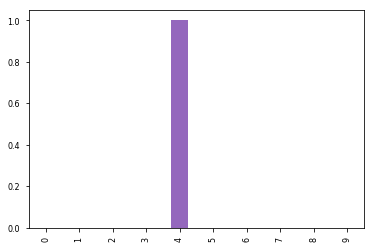

In [20]:
pd.Series(model.predict(x_train[13443].reshape(1, 784))[0]).plot(kind = 'bar')

#### salvando e carregando o modelo treinado


In [21]:
# salvando o modelo treinado
model.save('modelo_treinado.h5')

ImportError: `save_model` requires h5py.

In [ ]:
# carregando o modelo treinado
from keras.models import load_model

model = load_model('modelo_treinado.h5')